<a href="https://colab.research.google.com/github/Med-Rokaimi/SDE-LSTM-Fin/blob/main/LSTM_Levy_torchsde_calibrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM + Levy model



*   The levy parameters are calibrated by the torchsde library :
https://github.com/google-research/torchsde/tree/master
*   The dataset used in this notebook is : Italya 40 index https://www.investing.com/indices/investing.com-italy-40

*   Integrating torchsde has significantly increased the training time






In [ ]:
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchsde

from config.args import Config
from utils.helper import save
from data.data import create_dataset, pytorch_data_input
from utils.evaluation import  plot_trues_preds, metric, save_results
from utils.helper import create_exp, save_config_to_excel

warnings.filterwarnings("ignore")


The Levy Solver class

In [ ]:
class MertonSDE(nn.Module):
    def __init__(self):
        '''
         This function simulates asset price paths using the Merton jump-diffusion model. This model extends the classic Black-Scholes framework by incorporating random jumps, making it more suitable for capturing sudden and significant changes in asset prices.
        :param r: risk free rate
        :param m: meean of jump size
        :param v: standard deviation of jump
        :param lam: intensity of jump i.e. number of jumps per annum
        :param sigma: annaul standard deviation , for weiner process
        '''
        super(MertonSDE, self).__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.r = nn.Parameter(torch.tensor(0.02), requires_grad=False)
        self.m = nn.Parameter(torch.tensor(0.02), requires_grad=False)
        self.v = nn.Parameter(torch.tensor(0.02), requires_grad=False)
        self.lam = nn.Parameter(torch.tensor(0.02), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor(0.02), requires_grad=True)

    def f(self, t, y):

        return self.r * y


    def g(self, t, y):

        #return self.sigma * y.unsqueeze(-1)
        return self.sigma * y

    def forward (self,T, steps, Npaths):
        v = abs(self.v)
        torch.manual_seed(4)
        size = (steps, Npaths)
        dt = T / steps

        rates = torch.rand(steps, Npaths)
        poisson = torch.poisson(rates)
        poi_rv = torch.mul(poisson, torch.normal(self.m, v).cumsum(dim=0))
        geo = torch.cumsum(((self.r - self.sigma ** 2 / 2 - self.lam * (self.m + v ** 2 * 0.5)) * dt +
                            self.sigma * torch.sqrt(torch.tensor(dt)) * torch.normal(self.m, v)), dim=0)
        out = torch.exp(geo + poi_rv)
        return out

##LSTM model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, args, input_dim):
        super(LSTM, self).__init__()

        self.args = args
        self.hidden_dim = args.hidden_units1
        self.input_dim = input_dim
        self.output_dim = args.pred_len
        self.layer_dim = args.num_layers
        # LSTM layers
        self.lstm = nn.LSTM(
            self.input_dim, self.hidden_dim, self.layer_dim, batch_first=True, bidirectional=True, dropout=args.dropout
        )

        # Fully connected layer
        self.fc_1 = nn.Linear(self.hidden_dim * 2, args.hidden_units2)  # fully connected
        self.fc_2 = nn.Linear(args.hidden_units2, self.output_dim)  # fully connected last layer
        self.relu = nn.ReLU()
        self.Merton = MertonSDE()


    def forward(self, x, sde_path):

        #sde_path = self.Merton(self.output_dim, x.size(0), 1)
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim, device=x.device).requires_grad_()
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc_1(out)  # first dense
        out = self.relu(out)  # relu

        out = self.fc_2(out)  # final output
        out = out * sde_path

        return out

##Training class

In [ ]:
class TorchTrainer:
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        sde = MertonSDE()

        ts = torch.linspace(0, 1, x.size(0))
        y0 = torch.full(size=(x.size(0), 1), fill_value=0.1)
        with torch.no_grad():
            sde_path = torchsde.sdeint(sde, y0, ts)  # (t_size, batch_size, state_size) = (100, 3, 1).

        self.model.train()
        # Makes predictions
        yhat = self.model(x, sde_path)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        # Computes gradients

        loss.backward()
        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()
        # Returns the loss
        return loss.item()


    def train(self, train_loader, val_loader, batch_size, n_epochs, n_features, result_path):
        best_loss = float('inf')

        import time
        training_loss, validation_loss = [], []
        start_time = time.time()  # Record the start time
        for epoch in range(1, n_epochs + 1):
            self.optimizer.zero_grad()
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                sde = MertonSDE()
                ts = torch.linspace(0, 1, batch_size)
                y0 = torch.full(size=(batch_size, 1), fill_value=0.1)
                with torch.no_grad():
                    sde_path = torchsde.sdeint(sde, y0, ts)  # (t_size, batch_size, state_size) = (100, 3, 1).

                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val,sde_path )
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)

                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {training_loss:.6f}, Validation Loss: {val_loss:.6f}, Best Loss : {best_loss:.6f}')
            if val_loss < best_loss:
                best_loss = val_loss
                saved_model_path = save(self.model, result_path, 'best', save_model=True)
                print(f'Best model saved with loss: {best_loss:.6f}')

        end_time = time.time()  # Record the end time
        runtime = end_time - start_time  # Calculate the runtime
        return saved_model_path, self.model, runtime


    def evaluate(self, test_loader, batch_size=1, n_features=2):

        sde = MertonSDE()
        ts = torch.linspace(0, 1, batch_size)
        y0 = torch.full(size=(batch_size, 1), fill_value=0.1)


        with torch.no_grad():
            sde_path = torchsde.sdeint(sde, y0, ts)  # (t_size, batch_size, state_size) = (100, 3, 1).
            preds = []
            trues = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)

                self.model.eval()
                yhat = self.model(x_test, sde_path)
                yhat=yhat.cpu().data.numpy()
                preds.append(yhat)
                y_test=y_test.cpu().data.numpy()
                trues.append(y_test)

        preds = np.array(preds)
        trues = np.array(trues)
        preds = preds.reshape(-1, preds.shape[-1] )
        trues = trues.reshape(-1, trues.shape[-1])
        return trues, preds, self.model


##The main function

In [ ]:
################################################
# SetUp
################################################

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch_seed, rs_seed = 2012, 4
torch.manual_seed(torch_seed)
rs = np.random.RandomState(rs_seed)

result_path = "./results"
EXCEL_EXP_PATH = "./results/exp.xlsx"
saved_model_path = ""
dataset_name = "ITALY40.csv"
dataset_path = 'dataset/' + dataset_name
target_column = 'Price'  # the column name of the target time series (brent or WTI)

model_decriptipn = 'LSTM + Merton Jump calibrated by torchsde lib '
model_name = 'LSTM_Levy_Merton_torchsde'
save_model = True
config = Config(
    epochs=15,
    pred_len=1,
    seq_len=10,
    n_critic=1,
    model_name=model_name,
    dataset=target_column,
    lr=0.003054,
    num_layers=1,
    dropout=0.3,
    hidden_units1=8,
    hidden_units2=60,
    sde_parameters='N/A',
    batch_size=16,
    noise_type='normal',
    loss='MSELoss',
    opt='Adam',
    seeds={'torch_seed': torch_seed, 'rs_seed': rs_seed},
    sde='N/A'
)

#################################################
# Dataset
#################################################

# read the csv file
df = pd.read_csv(dataset_path)
#df = df[6:]

df = df[[target_column]]  # Price, WTI, SENT, GRACH
features = df.columns

# Exploratory Data Analysis (EDA) of Volatility Data
# from utils.helper import eda
# eda(df, target)

train_size, valid_size, test_size = 3285 , 200, 200# 2040, 259, 65 #2000, 180, 200
data = create_dataset(df, target_column, train_size, valid_size, test_size, config.seq_len, config.pred_len)
train_loader, val_loader, test_loader , test_loader_one = pytorch_data_input(data, config.batch_size )
print(f"Data : {dataset_name}, {data['X_train'].shape} , {data['y_train'].shape}")
print()

#################################################
# create expermint instance
#################################################
jobID, ex_results_path = create_exp(result_path, 'exp.csv', config.model_name)
#################################################
# Build the model
#################################################
model = LSTM(config, data['X_train'].shape[2])
optimizer = getattr(torch.optim, config.opt)(model.parameters(), lr=config.lr)

loss_fn = nn.MSELoss(reduction="mean")

ex = TorchTrainer(model, loss_fn=loss_fn, optimizer=optimizer)
input_dim = len(features)


#################################################
# Training the model
#################################################

best_model = None
is_train = True

if is_train:
    saved_model_path, trained_model, runtime= ex.train(train_loader, val_loader, batch_size=config.batch_size, n_epochs=config.epochs,
             n_features=input_dim, result_path=result_path)
    best_model= trained_model

else:
    print('training mode is off')

#################################################
# Testing the model
#################################################

if save_model:
    print(saved_model_path, "has been loaded")
    checkpoint = torch.load(saved_model_path)
    model.load_state_dict(checkpoint['g_state_dict'])

trues, preds, model = ex.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim)
print("opt", ex)


preds = preds[:, -1].reshape(-1, 1)
trues = trues[:, -1].reshape(-1, 1)
print(f" preds: {preds.shape}, trues {trues.shape}")




(200, 1) (200, 1)


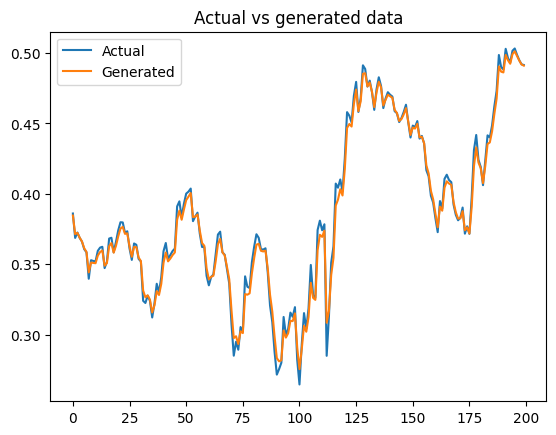

 MAE: 0.003250  , MSE 0.000038, RMSE 0.006124, MSPE 0.000328, MAPE 0.009237, R2 0.989296, KL 0.000138
save to excel
Merton Params: Sigma : 0.019999999552965164, Lam :0.019999999552965164, std 0.019999999552965164, m:0.019999999552965164
./results/exp.csv
New row appended to ./results/exp.csv 
./results/exp.csv
append to excel
Config(epochs=15, pred_len=1, seq_len=10, n_critic=1, model_name='LSTM_Levy_Merton_torchsde', dataset='Price', lr=0.003054, num_layers=1, dropout=0.3, hidden_units1=8, hidden_units2=60, sde_parameters='N/A', batch_size=16, noise_type='normal', opt='Adam', loss='MSELoss', seeds={'torch_seed': 2012, 'rs_seed': 4}, sde='N/A')
Index(['Price'], dtype='object')


In [ ]:
#################################################
# Ploting
#################################################

plot_trues_preds(trues, preds, ex_results_path)
metrics = metric(trues, preds)

save_results(trues, preds, metrics, ex_results_path)

# save result details with configs to exp.csv file
save_config_to_excel(jobID, ex_results_path, result_path + '/exp.csv', config, model_decriptipn,
                     best_model, metrics, {'train_size': train_size,
                                          'valid_size': valid_size, 'test_size': test_size}, runtime)



print(config)
print(df.columns)